In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from functools import partial
from collections import namedtuple
sys.path.append('../../')

import jax
import jax.numpy as jnp
import numpy as np
from sdebridge.sde import SDE
from sdebridge.diffusion_bridge import DiffusionBridge

jax.config.update('jax_platform_name', 'cpu')

import matplotlib.pyplot as plt
from matplotlib import colormaps
import einops
from ml_collections import ConfigDict

2024-01-29 14:20:51.172007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 14:20:51.172041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 14:20:51.173095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 14:20:52.556881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [4]:
def sample_ellipse(
    n_samples: int,
    scale: float = 1.0,
    shifts: np.ndarray = np.array([0.0, 0.0]),
    a: float = 1.0,
    b: float = 1.0,
) -> np.ndarray:
    theta = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    return scale * np.stack([x, y], axis=1) + shifts[None, :]

def evaluate_S(S: jnp.ndarray, n_bases: int) -> jnp.ndarray:
    ks = jnp.fft.fftshift(
        jnp.fft.fftfreq(n_bases, d=1.0/(2.0 * jnp.pi))
    )   # (n_bases, )
    n_samples = S.shape[0]
    S_coeffs = jnp.fft.fft(S, n=n_samples, axis=0) / jnp.sqrt(n_samples) # (n_samples, 2)
    S_coeffs = jnp.fft.fftshift(S_coeffs, axes=0) # (n_samples, 2)
    base = lambda k: jnp.exp(1j * jnp.arange(-n_samples//2, n_samples//2) * k) # (n_samples, )
    bases = jax.vmap(base)(ks) # (n_bases, n_samples)
    S_eval = jnp.matmul(bases, S_coeffs) / jnp.sqrt(n_samples) # (n_bases, 2)
    return S_eval

def evaluate_X(X_coeffs: jnp.ndarray, n_samples: int) -> jnp.ndarray:
    # assume X_coeffs contains both positive and negative frequencies, with the size of n_bases, 
    # specifically, n/2 negative frequencies, n/2-1 positive frequencies and 1 zero frequency for
    # even n, or n/2 negative frequencies, n/2 positive frequencies and 1 zero frequency for odd n
    n_bases = X_coeffs.shape[0]
    ks = jnp.fft.fftshift(
        jnp.fft.fftfreq(n_bases, d=1.0/(2.0 * jnp.pi))
    )   # (n_bases, )
    X_coeffs = X_coeffs / jnp.sqrt(n_samples)# (n_bases, 2)
    n_paddings = (n_samples - n_bases) // 2
    X_coeffs = jnp.pad(X_coeffs, ((n_paddings, n_paddings), (0, 0))) # (n_samples, 2)
    base = lambda k: jnp.exp(1j * jnp.arange(-n_samples//2, n_samples//2) * k) # (n_samples, )
    bases = jax.vmap(base)(ks) # (n_bases, n_samples)
    X_eval = jnp.matmul(bases, X_coeffs) / jnp.sqrt(n_samples) # (n_bases, 2)
    return X_eval

def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, sigma: float, alpha: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q(X_eval: jnp.ndarray, S0_eval: jnp.ndarray, n_samples: int, sigma: float, alpha: float) -> jnp.ndarray:
    ks = jnp.linspace(-2.0, 2.0, n_samples) # (n_samples, ) NOTE: here it doesn't have to be n_samples, could be any discretization
    kks = jnp.stack(jnp.meshgrid(ks, ks, indexing='xy'), axis=-1)
    kernel_func = partial(gaussian_kernel_2d, sigma=sigma, alpha=alpha)
    St_eval = X_eval + S0_eval   # (n_bases, 2)
    Q_eval = jax.vmap(
        jax.vmap(
            jax.vmap(kernel_func, 
                 (None, 0), 
                 0), 
            (None, 1), 
            1), 
        (0, None), 
        0)(St_eval, kks)        # (n_bases, n_samples, n_samples)
    return Q_eval

def evaluate_diffusion(X_coeffs: jnp.ndarray, S0: jnp.ndarray, n_bases: int, n_samples: int, sigma: float, alpha: float) -> jnp.ndarray:
    X_eval = evaluate_X(X_coeffs, n_samples=n_samples) # (n_bases, 2)
    S0_eval = evaluate_S(S0, n_bases=n_bases) # (n_bases, 2)
    Q_eval = evaluate_Q(X_eval, S0_eval, n_samples, sigma, alpha) # (n_bases, n_samples, n_samples)
    diffusion = jnp.fft.fftn(Q_eval, s=(n_bases, n_samples, n_samples), axes=(0, 1, 2), norm='ortho') # (n_bases, n_samples, n_samples)
    diffusion = einops.rearrange(diffusion, 'b s1 s2 -> b (s1 s2)')
    return diffusion

In [6]:
def batch_matmul(A: jnp.ndarray, B: jnp.ndarray) -> jnp.ndarray:
    """Batch matrix multiplication"""
    return jax.vmap(jnp.matmul, in_axes=(0, 0), out_axes=0)(A, B)


@partial(jax.jit, static_argnums=(0, ), backend='cpu')
def euler_maruyama(
    sde: SDE,
    initial_vals: jnp.ndarray,
    terminal_vals: jnp.ndarray,
    rng_key: jax.Array = jax.random.PRNGKey(0),
) -> dict:
    """Euler-Maruyama solver for SDEs

    initial_vals: (B, 2*N), complex64
    terminal_vals: (B, 2*N), complex64
    """
    enforce_terminal_constraint = terminal_vals is not None

    SolverState = namedtuple("SolverState", ["vals", "grads", "covs", "step_key"])
    init_state = SolverState(
        vals=initial_vals,
        grads=jnp.empty_like(initial_vals),
        covs=jnp.empty((initial_vals.shape[0], sde.dim*sde.n_bases, sde.dim*sde.n_bases), dtype=jnp.complex64),
        step_key=rng_key,
    )

    def euler_maruyama_step(state: SolverState, time: jnp.ndarray) -> tuple:
        """Euler-Maruyama step, NOTE: all the calculations are over batches"""
        time = jnp.expand_dims(time, axis=-1)
        time = jnp.tile(time, (state.vals.shape[0], 1))
        step_key, _ = jax.random.split(state.step_key)
        _drift = jax.vmap(sde.drift, in_axes=(0, 0))(state.vals, time)  # (B, 2*N)
        drift_step = _drift * sde.dt
        
        n_batches = state.vals.shape[0]
        _brownian = jax.random.normal(step_key, shape=(n_batches, sde.dim*sde.n_samples**2))  # (B, 2*N^2)
        brownian_step = _brownian * jnp.sqrt(sde.dt)

        _diffusion = jax.vmap(sde.diffusion, in_axes=(0, None))(
            state.vals, time
        )  # (B, 2*N, 2*N^2)
        diffusion_step = batch_matmul(_diffusion, brownian_step)  # (B, 2*N)

        _covariance = jax.vmap(sde.covariance, in_axes=(0, None))(state.vals, time) # (B, 2*N, 2*N)
        _inv_covariance = jax.vmap(partial(
            jnp.linalg.pinv,
            hermitian=True,
            rcond=None
        ))(_covariance)  # (B, 2*N, 2*N)


        # _inv_covariance = jax.vmap(sde.inv_covariance, in_axes=(0, None))(
        #     state.vals, time
        # )  # (B, 2*N, 2*N)

        grads = -batch_matmul(_inv_covariance, diffusion_step) / sde.dt  # (B, 2*N)

        new_vals = state.vals + drift_step + diffusion_step  # (B, 2*N)
        new_state = SolverState(
            vals=new_vals,
            grads=grads,
            covs=_covariance,
            step_key=step_key,
        )
        return new_state, (
            state.vals,
            state.grads,
            state.covs,
            state.step_key,
        )

    _, (trajectories, gradients, covariances, step_keys) = jax.lax.scan(
        euler_maruyama_step,
        init=init_state,
        xs=(sde.ts[:-1]),
        length=sde.N,
    )

    if enforce_terminal_constraint:
        trajectories = trajectories.at[-1].set(terminal_vals)
    return {
        "trajectories": jnp.swapaxes(trajectories, 0, 1),
        "gradients": jnp.swapaxes(gradients, 0, 1),
        "covariances": jnp.swapaxes(covariances, 0, 1),
        "last_key": step_keys[-1],
    }


#### Circles

S0 shape:  (64, 2)
S0_eval shape:  (2, 2)
ST shape:  (64, 2)
XT_coeffs shape: 
 (64, 2)


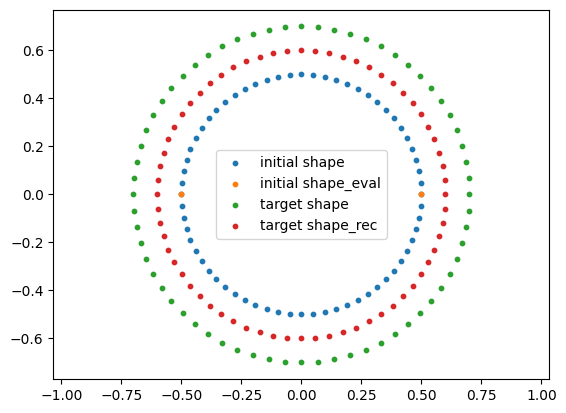

In [27]:
n_samples = 64
n_bases = 2

S0 = sample_ellipse(n_samples, scale=0.5)
S0_eval = evaluate_S(S0, n_bases=n_bases)
ST = sample_ellipse(n_samples, scale=0.7)
print("S0 shape: ", S0.shape)
print("S0_eval shape: ", S0_eval.shape)
print("ST shape: ", ST.shape)

X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)
XT = ST - S0
XT_coeffs = jnp.fft.fft(XT, norm="ortho", n=n_samples, axis=0)
XT_coeffs = jnp.fft.fftshift(XT_coeffs, axes=0)
XT_coeffs = XT_coeffs[(n_samples-n_bases)//2:(n_samples+n_bases)//2, :]
n_padding = (n_samples-n_bases)//2
XT_coeffs = jnp.pad(XT_coeffs, ((n_padding, n_padding), (0, 0)))
print("XT_coeffs shape: \n", XT_coeffs.shape) 
XT_coeffs = jnp.fft.ifftshift(XT_coeffs, axes=0)
XT_rec = jnp.fft.ifft(XT_coeffs, norm="ortho", n=n_samples, axis=0).real
ST_rec = XT_rec + S0


plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0].real, S0_eval[:, 1].real, s=10, label='initial shape_eval')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.scatter(ST_rec[:, 0], ST_rec[:, 1], s=10, label='target shape_rec')
plt.legend()
plt.axis('equal')
plt.show()

In [28]:
class GaussianKernelFuncBasisSDE(SDE):
    def __init__(self, config: ConfigDict):
        self.config = config

    def drift(self, val: jnp.ndarray, time: jnp.ndarray) -> jnp.ndarray:
        return jnp.zeros_like(val)
    
    @property
    def n_bases(self) -> int:
        return self.config.n_bases
    
    @property
    def n_samples(self) -> int:
        return self.config.n_samples
    
    def diffusion(self, val: jnp.ndarray, time: jnp.ndarray) -> jnp.ndarray:
        coeffs = jnp.stack(jnp.split(val, 2), axis=-1) 
        _diffusion_block = evaluate_diffusion(coeffs, self.config.S0, self.n_bases, self.n_samples, self.config.sigma, self.config.alpha)
        _zero_block = jnp.zeros_like(_diffusion_block)
        _diffusion = jnp.block([
            [_diffusion_block, _zero_block],
            [_zero_block, _diffusion_block]
        ])
        return _diffusion

In [29]:
sde_config = ConfigDict(
    {
        'S0': S0,
        'T': 1.0,
        'N': 50,
        'dim': 2,
        'n_bases': n_bases,
        'n_samples': n_samples,
        'sigma': 0.2,
        'alpha': 0.1,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)

In [30]:
X0 = jnp.zeros((n_bases*2, ), dtype=jnp.complex64)
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 50, 4)
Xs_coeffs shape:  (1, 50, 2, 2)
Xs_coeffs shape (padded):  (1, 50, 64, 2)
Xs_recon shape:  (1, 50, 64, 2)
Ss shape:  (1, 50, 64, 2)


(-0.5574691683053971,
 0.5524349004030228,
 -0.5596089243888855,
 0.5649189829826355)

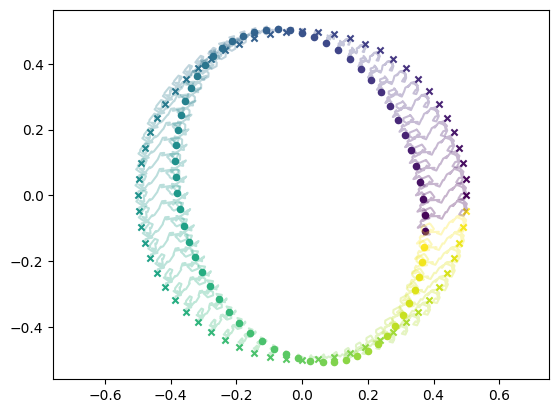

In [31]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_coeffs = jnp.stack(jnp.split(Xs_coeffs, 2, axis=-1), axis=-1)
print("Xs_coeffs shape: ", Xs_coeffs.shape)
n_padding = (n_samples-n_bases)//2
Xs_coeffs = jnp.pad(Xs_coeffs, pad_width=((0, 0), (0, 0), (n_padding, n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs_coeffs shape (padded): ", Xs_coeffs.shape)
Xs_coeffs = jnp.fft.ifftshift(Xs_coeffs, axes=-2)
Xs_recon = jnp.fft.ifft(Xs_coeffs, norm="ortho", n=n_samples, axis=-2)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=20, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=20, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.3)
plt.axis('equal')

#### Butterflies

In [32]:
from sdebridge.data_processing import butterfly_honrathi_pts, butterfly_amasina_pts

S0 shape:  (130, 2)
S0_eval shape:  (16, 2)
ST shape:  (120, 2)
XT_coeffs shape: 
 (16, 2)
XT_coeffs shape (padded): 
 (130, 2)


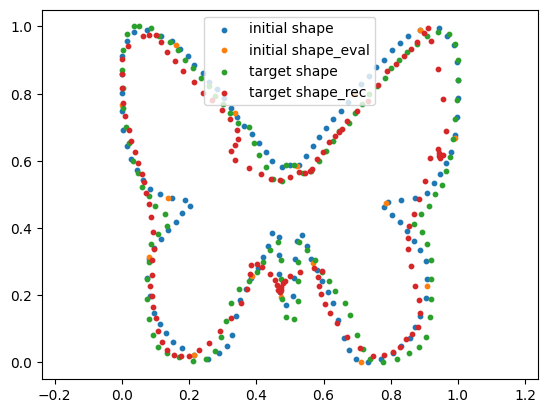

In [33]:
S0 = jnp.array(butterfly_honrathi_pts())[:, ::200][:, 1:].transpose()
ST = jnp.array(butterfly_amasina_pts())[:, ::200].transpose()
n_samples = S0.shape[0]
n_bases = 16
S0_eval = evaluate_S(S0, n_bases=n_bases)

print("S0 shape: ", S0.shape)
print("S0_eval shape: ", S0_eval.shape)
print("ST shape: ", ST.shape)

X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)
S0_coeffs = jnp.fft.fft(S0, norm="ortho", n=S0.shape[0], axis=0)
S0_coeffs = jnp.fft.fftshift(S0_coeffs, axes=0)
ST_coeffs = jnp.fft.fft(ST, norm="ortho", n=ST.shape[0], axis=0)
ST_coeffs = jnp.fft.fftshift(ST_coeffs, axes=0)

S0_coeffs = S0_coeffs[(S0.shape[0]-n_bases)//2:(S0.shape[0]+n_bases)//2, :]
ST_coeffs = ST_coeffs[(ST.shape[0]-n_bases)//2:(ST.shape[0]+n_bases)//2, :]
n_padding = (n_samples-n_bases)//2
XT_coeffs = ST_coeffs - S0_coeffs
print("XT_coeffs shape: \n", XT_coeffs.shape)
XT_coeffs = jnp.pad(XT_coeffs, ((n_padding, n_padding), (0, 0)))
print("XT_coeffs shape (padded): \n", XT_coeffs.shape)
XT_coeffs = jnp.fft.ifftshift(XT_coeffs, axes=0)
XT_rec = jnp.fft.ifft(XT_coeffs, norm="ortho", n=n_samples, axis=0).real
ST_rec = XT_rec + S0
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(S0_eval[:, 0].real, S0_eval[:, 1].real, s=10, label='initial shape_eval')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.scatter(ST_rec[:, 0], ST_rec[:, 1], s=10, label='target shape_rec')
plt.legend()
plt.axis('equal')
plt.show()

In [34]:
sde_config = ConfigDict(
    {
        'S0': S0,
        'T': 1.0,
        'N': 50,
        'dim': 2,
        'n_bases': n_bases,
        'n_samples': n_samples,
        'sigma': 0.1,
        'alpha': 0.05,
    }
)
sde = GaussianKernelFuncBasisSDE(sde_config)

In [35]:
X0 = jnp.zeros((n_bases*2, ), dtype=jnp.complex64)
forward_uncond = euler_maruyama(sde, initial_vals=jnp.expand_dims(X0, axis=0), terminal_vals=None)

Xs_coeffs shape:  (1, 50, 32)
Xs_coeffs shape:  (1, 50, 16, 2)
Xs_coeffs shape (padded):  (1, 50, 130, 2)
Xs_recon shape:  (1, 50, 130, 2)
Ss shape:  (1, 50, 130, 2)


(-0.09866214543581009,
 1.0717348828911781,
 -0.10394633263349534,
 1.2352637395262718)

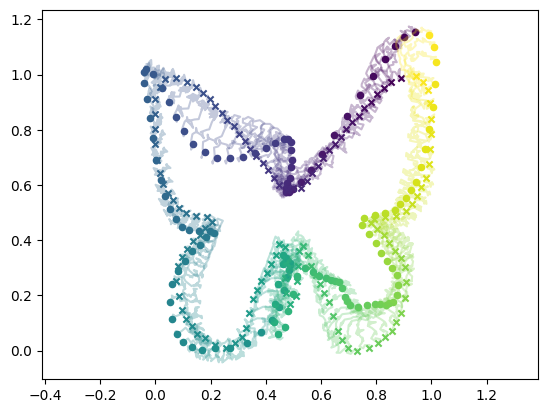

In [36]:
Xs_coeffs = forward_uncond["trajectories"]
print("Xs_coeffs shape: ", Xs_coeffs.shape)
Xs_coeffs = jnp.stack(jnp.split(Xs_coeffs, 2, axis=-1), axis=-1)
print("Xs_coeffs shape: ", Xs_coeffs.shape)
n_padding = (n_samples-n_bases)//2
Xs_coeffs = jnp.pad(Xs_coeffs, pad_width=((0, 0), (0, 0), (n_padding, n_padding), (0, 0)), mode='constant', constant_values=0)
print("Xs_coeffs shape (padded): ", Xs_coeffs.shape)
Xs_coeffs = jnp.fft.ifftshift(Xs_coeffs, axes=-2)
Xs_recon = jnp.fft.ifft(Xs_coeffs, norm="ortho", n=n_samples, axis=-2)
print("Xs_recon shape: ", Xs_recon.shape)

Ss = S0[None, None, :, :] + Xs_recon.real
print("Ss shape: ", Ss.shape)

# get the colormap
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, n_samples))
for i in range(n_samples):
    plt.scatter(Ss[0, 0, i, 0], Ss[0, 0, i, 1], s=20, marker='x', color=colors[i])
    plt.scatter(Ss[0, -1, i, 0], Ss[0, -1, i, 1], s=20, marker='o', color=colors[i])
    plt.plot(Ss[0, :, i, 0], Ss[0, :, i, 1], color=colors[i], alpha=0.3)
plt.axis('equal')